# Using OpenDR for Robotic Perception

OpenDR aims to provide a homogeneous, easy to use interface for various perception tools.

The main inference pipeline is the following:

```python
from opendr.perception.X import yLearner

yLearner(device='your inference device')
yLearner.download() # get a pretrained model
# or
yLearner.load('x') # load an existing model

````

After initializing the model, we can readily use it just by calling `infer()`:

```python
results = yLearner.infer(my_data)
```

The `results` are encapsulated OpenDR datatypes that provide a uniform interface among different Learners used for similar tasks.

Before doing anything, we will load some helper functions:

In [1]:
from matplotlib import pyplot as plt
from utils import VideoReader, FPSCounter
import cv2, numpy as np
%matplotlib inline

*matplotlib* is used for plotting, while *utils* provides an easy to use camera interface to grab frames, as well as FPS counter. *cv2* and *numpy* can be also useful for various tasks.

So let's start by trying a Pose Estimation algorithm. First, we need to import the corresponding learner class

In [2]:
from opendr.perception.pose_estimation import LightweightOpenPoseLearner

Also note that some tools also provide various utilities, such as visualization tools. Pose estimation provides the `draw_pose()` function that can be used for drawing the detected keypoints.

In [3]:
from opendr.perception.pose_estimation import draw_pose

Now we are ready to initialize the Learner, download and load a pretrained model.

In [4]:
pose_estimator = LightweightOpenPoseLearner(device='cuda')
pose_estimator.download(path=".", verbose=True)
pose_estimator.load("openpose_default")

Metadata json file already exists.
Trained model .pth file already exists.
Pretrained model download complete.


We also need an image provider and a way to measure the number of FPS:

In [5]:
image_provider = VideoReader(0)
fps_counter = FPSCounter()

So, we can start getting the frames from the web cam and then use the pose estimation algorithm to predict the keypoints and draw them onto the frame:

In [6]:
for counter, img in enumerate(image_provider):
    
    fps_counter.tic()
    # This is where we perform pose estimation
    poses = pose_estimator.infer(img)
    fps_counter.toc(img)

    # We also annotate the poses on the acquired frames
    for pose in poses:
        draw_pose(img, pose)
    
    cv2.imshow('Result', img)
    if cv2.waitKey(1) == ord('q'):
        break
    
cv2.destroyAllWindows()
image_provider.close()


Note that we can easily run the algorithm on `cpu`

In [7]:
pose_estimator = LightweightOpenPoseLearner(device='cpu')
pose_estimator.load("openpose_default")

The rest of the code does now change:

In [8]:
fps_counter = FPSCounter()
image_provider = VideoReader(0)

for counter, img in enumerate(image_provider):
    fps_counter.tic()
    poses = pose_estimator.infer(img)
    fps_counter.toc(img)

    for pose in poses:
        draw_pose(img, pose)
    
    cv2.imshow('Result', img)
    if cv2.waitKey(1) == ord('q'):
        break
    
cv2.destroyAllWindows()
image_provider.close()

We can then further optimize the model just by calling `optimize()` and setting other optional arguments (documented in OpenDR's documentation):

In [9]:
pose_estimator = LightweightOpenPoseLearner(device='cpu', num_refinement_stages=1, mobilenet_use_stride=True, half_precision=True)
pose_estimator.load("openpose_default")
pose_estimator.optimize()

Again, the main inference loop does not change


In [10]:
fps_counter = FPSCounter()
image_provider = VideoReader(0)

for counter, img in enumerate(image_provider):
    fps_counter.tic()
    poses = pose_estimator.infer(img)
    fps_counter.toc(img)

    for pose in poses:
        draw_pose(img, pose)
    
    cv2.imshow('Result', img)
    if cv2.waitKey(1) == ord('q'):
        break
    
cv2.destroyAllWindows()
image_provider.close()

We can also grab an isolated frame and perform inference on this:

In [11]:
image_provider = iter(VideoReader(0))
img = next(image_provider)
image_provider.close()

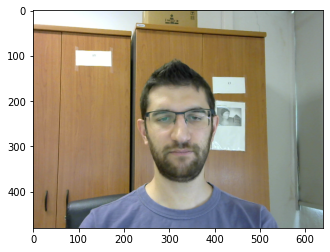

In [12]:
%matplotlib inline
plt.imshow(img[:, :, [2, 1, 0]])

In [13]:
poses = pose_estimator.infer(img)

Let's examine the output:

In [14]:
print(poses[0])

nose: [331, 264]
neck: [322, 472]
r_sho: [129, 472]
r_elb: [-1, -1]
r_wri: [-1, -1]
l_sho: [489, 472]
l_elb: [-1, -1]
l_wri: [-1, -1]
r_hip: [-1, -1]
r_knee: [-1, -1]
r_ank: [-1, -1]
l_hip: [-1, -1]
l_knee: [-1, -1]
l_ank: [-1, -1]
r_eye: [291, 234]
l_eye: [359, 226]
r_ear: [243, 254]
l_ear: [400, 244]



Note that OpenDR datatypes are cast into a human-readable format, allowing for easily examing what happens under the hood.